In [263]:
import numpy as np
import pandas as pd
import xgboost as xgb
from scipy import stats
import japanize_matplotlib
# import matplotlib as plt
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# ===============================================================
# 関数定義
# ===============================================================
def confidence_interval(mean: float, std: float, n: int, confidence: float = 0.95):
    t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
    margin = t_value * std / np.sqrt(n)
    return mean - margin, mean + margin

def handle_missing_val(df, features, enabled, min_horses):
    if not enabled:
        print("⚠ 欠損処理スキップ")
        return df

    print("欠損処理中...")
    processed_groups = []
    for race_id, group in df.groupby("race_id"):
        non_missing_mask = group[features].notnull().all(axis=1)
        if non_missing_mask.sum() < min_horses:
            continue
        for col in features:
            if group[col].isnull().any():
                group[col] = group[col].fillna(group[col].mean(skipna=True))
        processed_groups.append(group)
    df_processed = pd.concat(processed_groups, ignore_index=True)
    print(f"処理後: {len(df_processed)}件（元:{len(df)}）")
    return df_processed

def get_last_corner_position(row):
    for i in [4, 3, 2, 1]:
        val = row.get(f"position_{i}")
        if pd.notnull(val):
            return val
    return np.nan

# ===============================================================
# データ読み込み
# ===============================================================

# num_horses = 8
# target_course_ids = [301, 401, 402, 202, 502, 302]

# num_horses = 9
# target_course_ids = [202, 301, 402, 401, 602, 502, 601, 501, 1400]

# num_horses = 10
# target_course_ids = [202, 602, 301, 601, 502, 1201, 402, 501, 401, 1304, 1402, 700, 702, 1400, 1001, 802, 102]

# num_horses = 11
# target_course_ids = [602, 1304, 502, 501, 601, 202]

num_horses = 12
target_course_ids = [1304, 202, 102, 502, 901, 1001, 602, 501, 103, 1400, 1402, 201, 900, 1002, 1201, 601, 702]

course_label = "_".join(map(str, target_course_ids))
input_file = "input_全頭_編集後.csv"
df_all = pd.read_csv(input_file, encoding="utf-8")
df_all["race_date"] = pd.to_datetime(df_all["race_date"])
print(f"全データ: {len(df_all)}件")

# 並び替え
df_all = df_all.sort_values(["race_id", "horse_number"])

# ===============================================================
# ランニングスタイル判定（全期間・過去出走ベース）
# ===============================================================

print("🏇 ランニングスタイル（過去出走ベース）を算出中...")

# 最終コーナー順位を取得
df_all["last_corner_position"] = df_all.apply(get_last_corner_position, axis=1)
df_all["last_corner_position_rate"] = (
    df_all["last_corner_position"] / df_all["num_horses"]
)

# race_date順にソート（時系列処理のため）
df_all = df_all.sort_values(["horse_id", "race_date"]).reset_index(drop=True)

# 各馬について、各レース時点での「それ以前の平均通過順位率」を計算
def calc_past_avg(x):
    return x.expanding().mean().shift()

df_all["avg_last_corner_pos_rate_past"] = (
    df_all.groupby("horse_id", group_keys=False)["last_corner_position_rate"]
    .transform(calc_past_avg)
)

# 0.5未満なら「front」、以上なら「back」
df_all["running_style_type_past"] = np.where(
    df_all["avg_last_corner_pos_rate_past"] < 0.5, "front",
    np.where(df_all["avg_last_corner_pos_rate_past"].notnull(), "back", np.nan)
)

# ===============================================================
# 指定頭数×コースの分析対象データに絞る
# ===============================================================
df_target = df_all[
    (df_all["num_horses"] == num_horses) &
    (df_all["course_id"].isin(target_course_ids))
].copy()

# 欠損値処理
handle_missing = True
min_non_missing_horses = num_horses
missing_check_features = ["time_index_average_2", "jockey_place_rate_100"]

df_target = handle_missing_val(
    df_target,
    features=missing_check_features,
    enabled=handle_missing,
    min_horses=min_non_missing_horses
)

# ===============================================================
# 特徴量作成
# ===============================================================

# (1) タイム指数平均との差
race_avg = df_target.groupby("race_id")["time_index_average_2"].transform("mean")
df_target["time_index_diff_from_avg"] = df_target["time_index_average_2"] - race_avg

# (2) 騎手勝率平均との差
race_avg = df_target.groupby("race_id")["jockey_place_rate_100"].transform("mean")
df_target["jockey_place_rate_diff_from_avg"] = (
    df_target["jockey_place_rate_100"] - race_avg
)

# (3) 馬番別勝率（指定コース×頭数）
df_target["is_win"] = (df_target["finish_rank"] == 1).astype(int)
win_rate_by_horse_number = (
    df_target.groupby(["course_id", "horse_number"])["is_win"]
    .mean()
    .reset_index()
    .rename(columns={"is_win": "win_rate_by_course_horse_number"})
)
df_target = df_target.merge(
    win_rate_by_horse_number,
    on=["course_id", "horse_number"],
    how="left"
)
# 平均との差
race_avg = df_target.groupby("race_id")["win_rate_by_course_horse_number"].transform("mean")
df_target["win_rate_by_course_horse_number_diff_from_avg"] = (
    df_target["win_rate_by_course_horse_number"] - race_avg
)
# (4) ランニングスタイル別勝率（指定コース×頭数×ランニングスタイル）
# 各馬ごとに全期間の平均通過順位率を算出
horse_mean_style_rate = (
    df_all.groupby("horse_id")["last_corner_position_rate"]
    .mean()
    .reset_index()
    .rename(columns={"last_corner_position_rate": "mean_last_corner_pos_rate_all"})
)
# スタイルを固定的に分類（全期間平均ベース）
horse_mean_style_rate["running_style_type_overall"] = np.where(
    horse_mean_style_rate["mean_last_corner_pos_rate_all"] < 0.5, "front", "back"
)
# 指定コースのみを抽出
df_course = df_all[df_all["course_id"].isin(target_course_ids)].copy()
# 各馬の固定スタイル（全期間平均ベース）を付与
df_course = df_course.merge(
    horse_mean_style_rate[["horse_id", "running_style_type_overall"]],
    on="horse_id",
    how="left"
)
# コース × front/back ごとに勝率を算出
course_style_win_summary_target = (
    df_course.groupby(["course_id", "running_style_type_overall"])
    .agg(
        total_runs=("horse_id", "count"),                    # 出走数（分母）
        total_wins=("finish_rank", lambda x: (x == 1).sum()) # 勝利数（分子）
    )
    .reset_index()
)
# 勝率を計算
course_style_win_summary_target["win_rate_overall"] = (
    course_style_win_summary_target["total_wins"] / course_style_win_summary_target["total_runs"]
)
# 出力
# course_style_win_summary_target には
# ["course_id", "running_style_type_overall", "win_rate_overall"] が含まれている前提
df_target = df_target.merge(
    course_style_win_summary_target[["course_id", "running_style_type_overall", "win_rate_overall"]],
    left_on=["course_id", "running_style_type_past"],
    right_on=["course_id", "running_style_type_overall"],
    how="left"
)
# 不要なカラムを整理
df_target = df_target.drop(columns=["running_style_type_overall"])
# カラム名をわかりやすくリネーム
df_target = df_target.rename(columns={
    "win_rate_overall": "running_style_win_prob"
})
# 平均との差
race_avg = df_target.groupby("race_id")["running_style_win_prob"].transform("mean")
df_target["running_style_win_prob_diff_from_avg"] = (
    df_target["running_style_win_prob"] - race_avg
)

# (5) 前方／後方全体勝率（指定コース×頭数）
# 各馬ごとに全期間の平均通過順位率を算出
horse_mean_style_rate = (
    df_all.groupby("horse_id")["last_corner_position_rate"]
    .mean()
    .reset_index()
    .rename(columns={"last_corner_position_rate": "mean_last_corner_pos_rate_all"})
)
# スタイルを固定的に分類（全期間平均ベース）
horse_mean_style_rate["running_style_type_overall"] = np.where(
    horse_mean_style_rate["mean_last_corner_pos_rate_all"] < 0.5, "front", "back"
)
# 指定コースに絞る
# horse_mean_style_rate = horse_mean_style_rate[horse_mean_style_rate["course_id"].isin(target_course_ids)].copy()
# 指定コースのデータに絞る
df_course = df_all[df_all["course_id"].isin(target_course_ids)].copy()
# 各馬の全期間固定スタイルを df_course に付与
df_course = df_course.merge(
    horse_mean_style_rate[["horse_id", "running_style_type_overall"]],
    on="horse_id",
    how="left"
)
# 各レースで front/back の頭数を計算
race_style_counts = (
    df_course.groupby(["course_id", "race_id", "running_style_type_overall"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
race_style_counts["num_front"] = race_style_counts.get("front", 0)
race_style_counts["num_back"] = race_style_counts.get("back", 0)
race_style_counts["total"] = race_style_counts["num_front"] + race_style_counts["num_back"]
race_style_counts["ratio_front"] = race_style_counts["num_front"] / race_style_counts["total"]
race_style_counts["ratio_back"] = race_style_counts["num_back"] / race_style_counts["total"]
# df_course に割合を結合
df_course = df_course.merge(
    race_style_counts[["course_id", "race_id", "ratio_front", "ratio_back"]],
    on=["course_id", "race_id"],
    how="left"
)
# 割合を丸めてカテゴリ化
df_course["ratio_front_round"] = df_course["ratio_front"].round(2)
df_course["ratio_back_round"] = df_course["ratio_back"].round(2)
# front/back の割合ごとに勝率を算出（finish_rank==1を直接カウント）
style_win_ratio_df = (
    df_course.groupby(["course_id", "running_style_type_overall", "ratio_front_round", "ratio_back_round"])
    .agg(
        total_horses=("horse_id", "count"),
        total_wins=("finish_rank", lambda x: (x == 1).sum())
    )
    .reset_index()
)
style_win_ratio_df["win_rate"] = style_win_ratio_df["total_wins"] / style_win_ratio_df["total_horses"]
# カラム名を整理
style_win_ratio_df = style_win_ratio_df.rename(columns={
#    "running_style_type_overall": "style",
#    "ratio_front_round": "ratio_front",
#    "ratio_back_round": "ratio_back"
})
# 各レースで front/back の頭数を計算（running_style_type_past ベース）
race_style_counts = (
    df_target.groupby(["course_id", "race_id", "running_style_type_past"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
# front/back の割合を算出
race_style_counts["num_front"] = race_style_counts.get("front", 0)
race_style_counts["num_back"] = race_style_counts.get("back", 0)
race_style_counts["total"] = race_style_counts["num_front"] + race_style_counts["num_back"]
race_style_counts["ratio_front"] = race_style_counts["num_front"] / race_style_counts["total"]
race_style_counts["ratio_back"] = race_style_counts["num_back"] / race_style_counts["total"]
# 割合を丸める
race_style_counts["ratio_front_round"] = race_style_counts["ratio_front"].round(2)
race_style_counts["ratio_back_round"] = race_style_counts["ratio_back"].round(2)
# df_target にマージ
df_target = df_target.merge(
    race_style_counts[["course_id", "race_id", "ratio_front_round", "ratio_back_round"]],
    on=["course_id", "race_id"],
    how="left"
)
# style_win_ratio_df と結合して勝率を付与
df_target = df_target.merge(
    style_win_ratio_df[
        ["course_id", "running_style_type_overall", "ratio_front_round", "ratio_back_round", "win_rate"]
    ],
    left_on=["course_id", "running_style_type_past", "ratio_front_round", "ratio_back_round"],
    right_on=["course_id", "running_style_type_overall", "ratio_front_round", "ratio_back_round"],
    how="left"
)
# 勝率カラムをリネーム
df_target = df_target.rename(columns={"win_rate": "style_win_prob_by_ratio"})
# 不要な結合キー列を削除
df_target = df_target.drop(columns=["running_style_type_overall"])
# 平均との差
race_avg = df_target.groupby("race_id")["style_win_prob_by_ratio"].transform("mean")
df_target["style_win_prob_by_ratio_diff_from_avg"] = (
    df_target["style_win_prob_by_ratio"] - race_avg
)
# 出力確認
df_target.to_csv(f"C:\\Users\\ryo\\Downloads\\df_target.csv", index=False, encoding="utf-8-sig")

# ===============================================================
# 相互作用項（2変数の掛け算）
# ===============================================================

df_target["time_index_diff_from_avg_and_jockey_place_rate_diff_from_avg"] = (
    df_target["time_index_diff_from_avg"] * df_target["jockey_place_rate_diff_from_avg"]
)

df_target["time_index_diff_from_avg_and_win_rate_by_course_horse_number"] = (
    df_target["time_index_diff_from_avg"] * df_target["win_rate_by_course_horse_number"]
)

df_target["time_index_diff_from_avg_and_running_style_win_prob"] = (
    df_target["time_index_diff_from_avg"] * df_target["running_style_win_prob"]
)

df_target["time_index_diff_from_avg_and_style_win_prob_by_ratio"] = (
    df_target["time_index_diff_from_avg"] * df_target["style_win_prob_by_ratio"]
)

df_target["jockey_place_rate_diff_from_avg_and_win_rate_by_course_horse_number"] = (
    df_target["jockey_place_rate_diff_from_avg"] * df_target["win_rate_by_course_horse_number"]
)

df_target["jockey_place_rate_diff_from_avg_and_running_style_win_prob"] = (
    df_target["jockey_place_rate_diff_from_avg"] * df_target["running_style_win_prob"]
)

df_target["jockey_place_rate_diff_from_avg_and_style_win_prob_by_ratio"] = (
    df_target["jockey_place_rate_diff_from_avg"] * df_target["style_win_prob_by_ratio"]
)

df_target["win_rate_by_course_horse_number_and_running_style_win_prob"] = (
    df_target["win_rate_by_course_horse_number"] * df_target["running_style_win_prob"]
)

df_target["win_rate_by_course_horse_number_and_style_win_prob_by_ratio"] = (
    df_target["win_rate_by_course_horse_number"] * df_target["style_win_prob_by_ratio"]
)

df_target["running_style_win_prob_and_style_win_prob_by_ratio"] = (
    df_target["running_style_win_prob"] * df_target["style_win_prob_by_ratio"]
)


全データ: 634887件
🏇 ランニングスタイル（過去出走ベース）を算出中...
欠損処理中...
処理後: 55260件（元:105564）


In [265]:
# ===============================================================
# 特徴量リスト
# ===============================================================
features = [
#    "time_index_diff_from_avg",
    "jockey_place_rate_diff_from_avg",
#    "win_rate_by_course_horse_number",
#    "running_style_win_prob",
#    "style_win_prob_by_ratio",
    "win_rate_by_course_horse_number_diff_from_avg",
    "running_style_win_prob_diff_from_avg",
    "style_win_prob_by_ratio_diff_from_avg",
    # ここから相互作用項
#    "time_index_diff_from_avg_and_jockey_place_rate_diff_from_avg",
#    "time_index_diff_from_avg_and_win_rate_by_course_horse_number",
#    "time_index_diff_from_avg_and_running_style_win_prob",
#    "time_index_diff_from_avg_and_style_win_prob_by_ratio",
#    "jockey_place_rate_diff_from_avg_and_win_rate_by_course_horse_number",
#    "jockey_place_rate_diff_from_avg_and_running_style_win_prob",
#    "jockey_place_rate_diff_from_avg_and_style_win_prob_by_ratio",
#    "win_rate_by_course_horse_number_and_running_style_win_prob",
#    "win_rate_by_course_horse_number_and_style_win_prob_by_ratio",
#    "running_style_win_prob_and_style_win_prob_by_ratio",
]

# ===============================================================
# ラベル作成
# ===============================================================
df_target["is_top4"] = (
    df_target.groupby("race_id")["finish_rank"]
    .rank(method="first") <= df_target["num_horses"] / 2
).astype(int)

# ===============================================================
# 🔁 コース別 Walk-Forward 学習
# ===============================================================

start_year = 2021
end_year = 2024
num_train_races = 100
bet_amount = 100

all_course_pop_stats = []
all_wf_predictions = []  # ←全コースまとめ用リスト

for course_id in target_course_ids:

    print("\n" + "="*70)
    print(f"🚩 コース {course_id} の Walk-Forward を開始")
    print("="*70)

    # --------------------------------------------------------------
    # コース別データ抽出
    # --------------------------------------------------------------
    df_course = df_target[
        (df_target["course_id"] == course_id) &
        (df_target["race_date"].dt.year >= start_year) &
        (df_target["race_date"].dt.year <= end_year)
    ].copy()

    if df_course.empty:
        print(f"⚠ コース {course_id} のデータがありません。スキップします")
        continue

    df_course = df_course.sort_values(["race_date", "race_id", "horse_number"]).reset_index(drop=True)
    race_ids = df_course["race_id"].unique()

    if len(race_ids) <= num_train_races:
        print(f"⚠ コース {course_id} のレース数が少ないためスキップ（{len(race_ids)}件）")
        continue

    print(f"対象レース数: {len(race_ids)}")
    print("Walk-Forward 予測を開始します...\n")

    wf_predictions = []

    # --------------------------------------------------------------
    # Walk-Forward Loop
    # --------------------------------------------------------------
    for i in tqdm(range(num_train_races, len(race_ids)),
                  desc=f"Course {course_id} Progress"):

        train_races = race_ids[:i]
        val_race = race_ids[i]

        df_train = df_course[df_course["race_id"].isin(train_races)].copy()
        df_val = df_course[df_course["race_id"] == val_race].copy()

        # 人気1は除外（学習のみ）
        df_train_filtered = df_train[~df_train["popularity"].isin([1])]

        X_train = df_train_filtered[features]
        y_train = (df_train_filtered["finish_rank"] <= df_train_filtered["num_horses"] / 2).astype(int)

        X_val = df_val[features]

        # ------------------------
        # XGBoost モデル
        # ------------------------
        model_wf = xgb.XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            random_state=42,
            subsample=0.8,
            colsample_bytree=0.8,
            base_score=0.5,
            max_depth=3,
            learning_rate=0.06,
            n_estimators=100,
            reg_alpha=0.5,
            reg_lambda=1.0,
        )

        model_wf.fit(X_train, y_train)

        # ------------------------
        # 予測
        # ------------------------
        df_val["pred_prob"] = model_wf.predict_proba(X_val)[:, 1]
        df_val = df_val.sort_values("pred_prob", ascending=False)
        df_val["selected"] = 0
        num_select = int(df_val["num_horses"].iloc[0] / 2)
        df_val.iloc[:num_select, df_val.columns.get_loc("selected")] = 1

        wf_predictions.append(df_val)

    wf_pred_df = pd.concat(wf_predictions, ignore_index=True)
    all_wf_predictions.append(wf_pred_df)  # ←全コースまとめ用に追加

    print(f"✅ コース {course_id} の Walk-Forward 完了！")

    # ===============================================================
    # コース別 人気別成績（1着のみ）
    # ===============================================================
    df_pred_top1 = wf_pred_df.loc[
        wf_pred_df.groupby("race_id")["pred_prob"].idxmax()
    ].copy()
    df_pred_top1["is_hit"] = (df_pred_top1["finish_rank"] == 1).astype(int)
    df_pred_top1["payout"] = df_pred_top1["is_hit"] * df_pred_top1["odds"] * bet_amount

    num_horses_course = int(df_pred_top1["num_horses"].max())
    pop_stats = (
        df_pred_top1.groupby("popularity")
        .agg(
            total_pred=("is_hit", "count"),
            hits=("is_hit", "sum"),
            total_payout=("payout", "sum"),
        )
    )
    pop_stats = pop_stats.reindex(range(1, num_horses_course + 1), fill_value=0).reset_index()
    pop_stats.rename(columns={"index": "popularity"}, inplace=True)
    pop_stats["total_bet"] = pop_stats["total_pred"] * bet_amount
    pop_stats["accuracy"] = pop_stats["hits"] / pop_stats["total_pred"].replace(0, pd.NA)
    pop_stats["roi"] = pop_stats["total_payout"] / pop_stats["total_bet"].replace(0, pd.NA)

    print(f"\n📊 コース {course_id} 人気別成績")
    print(pop_stats)

    pop_stats["course_id"] = course_id
    all_course_pop_stats.append(pop_stats)

# ===============================================================
# 🔹 全コースまとめ 人気別成績（1着のみ）
# ===============================================================
wf_pred_all_courses = pd.concat(all_wf_predictions, ignore_index=True)

df_pred_top1_all = wf_pred_all_courses.loc[
    wf_pred_all_courses.groupby("race_id")["pred_prob"].idxmax()
].copy()
df_pred_top1_all["is_hit"] = (df_pred_top1_all["finish_rank"] == 1).astype(int)
df_pred_top1_all["payout"] = df_pred_top1_all["is_hit"] * df_pred_top1_all["odds"] * bet_amount

num_horses_all = int(df_pred_top1_all["num_horses"].max())
pop_stats_all = (
    df_pred_top1_all.groupby("popularity")
    .agg(
        total_pred=("is_hit", "count"),
        hits=("is_hit", "sum"),
        total_payout=("payout", "sum"),
    )
)
pop_stats_all = pop_stats_all.reindex(range(1, num_horses_all + 1), fill_value=0).reset_index()
pop_stats_all.rename(columns={"index": "popularity"}, inplace=True)
pop_stats_all["total_bet"] = pop_stats_all["total_pred"] * bet_amount
pop_stats_all["accuracy"] = pop_stats_all["hits"] / pop_stats_all["total_pred"].replace(0, pd.NA)
pop_stats_all["roi"] = pop_stats_all["total_payout"] / pop_stats_all["total_bet"].replace(0, pd.NA)

print("\n\n======================================")
print("🏇 全コース人気別成績まとめ（1着のみ）")
print("======================================")
print(pop_stats_all)



🚩 コース 1304 の Walk-Forward を開始
対象レース数: 714
Walk-Forward 予測を開始します...



Course 1304 Progress: 100%|██████████████████████████████████████████████████████████| 614/614 [00:56<00:00, 10.86it/s]


✅ コース 1304 の Walk-Forward 完了！

📊 コース 1304 人気別成績
    popularity  total_pred  hits  total_payout  total_bet  accuracy        roi
0            1         156    76       13300.0      15600  0.487179   0.852564
1            2         106    29       10520.0      10600  0.273585   0.992453
2            3          79    13        7820.0       7900  0.164557   0.989873
3            4          73     6        4900.0       7300  0.082192   0.671233
4            5          55     4        3870.0       5500  0.072727   0.703636
5            6          40     4        5580.0       4000  0.100000   1.395000
6            7          27     0           0.0       2700  0.000000   0.000000
7            8          32     0           0.0       3200  0.000000   0.000000
8            9          16     1        6710.0       1600  0.062500   4.193750
9           10          20     0           0.0       2000  0.000000   0.000000
10          11           7     1        7320.0        700  0.142857  10.457143
11  

Course 202 Progress: 100%|███████████████████████████████████████████████████████████| 331/331 [00:28<00:00, 11.41it/s]


✅ コース 202 の Walk-Forward 完了！

📊 コース 202 人気別成績
    popularity  total_pred  hits  total_payout  total_bet  accuracy       roi
0            1         110    57       10520.0      11000  0.518182  0.956364
1            2          74     6        1990.0       7400  0.081081  0.268919
2            3          60     4        1930.0       6000  0.066667  0.321667
3            4          32     0           0.0       3200  0.000000  0.000000
4            5          11     0           0.0       1100  0.000000  0.000000
5            6          20     0           0.0       2000  0.000000  0.000000
6            7           8     0           0.0        800  0.000000  0.000000
7            8           8     0           0.0        800  0.000000  0.000000
8            9           3     0           0.0        300  0.000000  0.000000
9           10           2     0           0.0        200  0.000000  0.000000
10          11           1     0           0.0        100  0.000000  0.000000
11          12    

Course 102 Progress: 100%|███████████████████████████████████████████████████████████| 257/257 [00:21<00:00, 11.90it/s]


✅ コース 102 の Walk-Forward 完了！

📊 コース 102 人気別成績
    popularity  total_pred  hits  total_payout  total_bet  accuracy       roi
0            1          66    31        5450.0       6600  0.469697  0.825758
1            2          58    10        4270.0       5800  0.172414  0.736207
2            3          44     5        3180.0       4400  0.113636  0.722727
3            4          26     1        1040.0       2600  0.038462       0.4
4            5          21     2        2280.0       2100  0.095238  1.085714
5            6          15     2        2220.0       1500  0.133333      1.48
6            7          10     0           0.0       1000       0.0       0.0
7            8           5     0           0.0        500       0.0       0.0
8            9           4     0           0.0        400       0.0       0.0
9           10           5     0           0.0        500       0.0       0.0
10          11           3     0           0.0        300       0.0       0.0
11          12    

Course 502 Progress: 100%|███████████████████████████████████████████████████████████| 261/261 [00:19<00:00, 13.18it/s]


✅ コース 502 の Walk-Forward 完了！

📊 コース 502 人気別成績
    popularity  total_pred  hits  total_payout  total_bet  accuracy       roi
0            1          59    30        6280.0       5900  0.508475  1.064407
1            2          41     4        1520.0       4100  0.097561  0.370732
2            3          28     3        2010.0       2800  0.107143  0.717857
3            4          29     1         800.0       2900  0.034483  0.275862
4            5          19     3        3740.0       1900  0.157895  1.968421
5            6          20     4        6240.0       2000  0.200000  3.120000
6            7          18     0           0.0       1800  0.000000  0.000000
7            8          10     0           0.0       1000  0.000000  0.000000
8            9          14     0           0.0       1400  0.000000  0.000000
9           10          12     1        2440.0       1200  0.083333  2.033333
10          11           8     0           0.0        800  0.000000  0.000000
11          12    

Course 901 Progress: 100%|███████████████████████████████████████████████████████████| 160/160 [00:12<00:00, 13.33it/s]


✅ コース 901 の Walk-Forward 完了！

📊 コース 901 人気別成績
    popularity  total_pred  hits  total_payout  total_bet  accuracy       roi
0            1          27     8        1860.0       2700  0.296296  0.688889
1            2          31     6        2680.0       3100  0.193548  0.864516
2            3          20     3        1680.0       2000  0.150000  0.840000
3            4          25     7        5830.0       2500  0.280000  2.332000
4            5          17     2        2400.0       1700  0.117647  1.411765
5            6           8     0           0.0        800  0.000000  0.000000
6            7          10     0           0.0       1000  0.000000  0.000000
7            8           9     1        2580.0        900  0.111111  2.866667
8            9           4     0           0.0        400  0.000000  0.000000
9           10           6     0           0.0        600  0.000000  0.000000
10          11           2     0           0.0        200  0.000000  0.000000
11          12    

Course 1001 Progress: 100%|██████████████████████████████████████████████████████████| 130/130 [00:11<00:00, 11.35it/s]


✅ コース 1001 の Walk-Forward 完了！

📊 コース 1001 人気別成績
    popularity  total_pred  hits  total_payout  total_bet  accuracy       roi
0            1          27     9        1860.0       2700  0.333333  0.688889
1            2          11     1         400.0       1100  0.090909  0.363636
2            3          16     1         620.0       1600  0.062500  0.387500
3            4          10     0           0.0       1000  0.000000  0.000000
4            5          14     0           0.0       1400  0.000000  0.000000
5            6          14     0           0.0       1400  0.000000  0.000000
6            7          13     1        3100.0       1300  0.076923  2.384615
7            8           6     0           0.0        600  0.000000  0.000000
8            9           7     0           0.0        700  0.000000  0.000000
9           10           5     0           0.0        500  0.000000  0.000000
10          11           4     0           0.0        400  0.000000  0.000000
11          12  

Course 602 Progress: 100%|███████████████████████████████████████████████████████████| 214/214 [00:15<00:00, 13.41it/s]


✅ コース 602 の Walk-Forward 完了！

📊 コース 602 人気別成績
    popularity  total_pred  hits  total_payout  total_bet  accuracy       roi
0            1          48    22        3810.0       4800  0.458333  0.793750
1            2          35     8        2870.0       3500  0.228571  0.820000
2            3          32     2        1330.0       3200  0.062500  0.415625
3            4          24     3        2590.0       2400  0.125000  1.079167
4            5          18     1        1240.0       1800  0.055556  0.688889
5            6          19     1        1340.0       1900  0.052632  0.705263
6            7          12     0           0.0       1200  0.000000  0.000000
7            8          10     0           0.0       1000  0.000000  0.000000
8            9           5     0           0.0        500  0.000000  0.000000
9           10           5     0           0.0        500  0.000000  0.000000
10          11           5     0           0.0        500  0.000000  0.000000
11          12    

Course 501 Progress: 100%|███████████████████████████████████████████████████████████| 129/129 [00:11<00:00, 11.48it/s]


✅ コース 501 の Walk-Forward 完了！

📊 コース 501 人気別成績
    popularity  total_pred  hits  total_payout  total_bet  accuracy       roi
0            1          33    13        2620.0       3300  0.393939  0.793939
1            2          21     5        2410.0       2100  0.238095  1.147619
2            3          18     2         980.0       1800  0.111111  0.544444
3            4          12     2        1440.0       1200  0.166667  1.200000
4            5           8     0           0.0        800  0.000000  0.000000
5            6           6     1         910.0        600  0.166667  1.516667
6            7           8     0           0.0        800  0.000000  0.000000
7            8           7     0           0.0        700  0.000000  0.000000
8            9           6     0           0.0        600  0.000000  0.000000
9           10           3     1        2290.0        300  0.333333  7.633333
10          11           3     0           0.0        300  0.000000  0.000000
11          12    

Course 103 Progress: 100%|███████████████████████████████████████████████████████████| 105/105 [00:07<00:00, 13.85it/s]


✅ コース 103 の Walk-Forward 完了！

📊 コース 103 人気別成績
    popularity  total_pred  hits  total_payout  total_bet  accuracy        roi
0            1          25    13        2100.0       2500  0.520000   0.840000
1            2          14     1         480.0       1400  0.071429   0.342857
2            3           9     1         530.0        900  0.111111   0.588889
3            4          11     1         630.0       1100  0.090909   0.572727
4            5          13     1         760.0       1300  0.076923   0.584615
5            6          11     0           0.0       1100  0.000000   0.000000
6            7           8     1        3420.0        800  0.125000   4.275000
7            8           2     0           0.0        200  0.000000   0.000000
8            9           5     1        6700.0        500  0.200000  13.400000
9           10           3     0           0.0        300  0.000000   0.000000
10          11           2     0           0.0        200  0.000000   0.000000
11    

Course 1400 Progress: 100%|████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.34it/s]


✅ コース 1400 の Walk-Forward 完了！

📊 コース 1400 人気別成績
    popularity  total_pred  hits  total_payout  total_bet  accuracy   roi
0            1           6     0           0.0        600       0.0   0.0
1            2           3     0           0.0        300       0.0   0.0
2            3           3     1         450.0        300  0.333333   1.5
3            4           0     0           0.0          0      <NA>  <NA>
4            5           2     0           0.0        200       0.0   0.0
5            6           1     0           0.0        100       0.0   0.0
6            7           0     0           0.0          0      <NA>  <NA>
7            8           0     0           0.0          0      <NA>  <NA>
8            9           0     0           0.0          0      <NA>  <NA>
9           10           0     0           0.0          0      <NA>  <NA>
10          11           1     0           0.0        100       0.0   0.0
11          12           0     0           0.0          0      <

Course 1402 Progress: 100%|████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.43it/s]


✅ コース 1402 の Walk-Forward 完了！

📊 コース 1402 人気別成績
    popularity  total_pred  hits  total_payout  total_bet accuracy   roi
0            1           2     1         230.0        200      0.5  1.15
1            2           5     2         810.0        500      0.4  1.62
2            3           2     1         510.0        200      0.5  2.55
3            4           0     0           0.0          0     <NA>  <NA>
4            5           1     0           0.0        100      0.0   0.0
5            6           3     0           0.0        300      0.0   0.0
6            7           3     0           0.0        300      0.0   0.0
7            8           3     0           0.0        300      0.0   0.0
8            9           0     0           0.0          0     <NA>  <NA>
9           10           0     0           0.0          0     <NA>  <NA>
10          11           1     0           0.0        100      0.0   0.0
11          12           0     0           0.0          0     <NA>  <NA>

🚩 

Course 201 Progress: 100%|█████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.64it/s]


✅ コース 201 の Walk-Forward 完了！

📊 コース 201 人気別成績
    popularity  total_pred  hits  total_payout  total_bet  accuracy        roi
0            1           6     5        1190.0        600  0.833333   1.983333
1            2           9     3         960.0        900  0.333333   1.066667
2            3           5     2        1030.0        500       0.4       2.06
3            4           2     0           0.0        200       0.0        0.0
4            5           4     1         890.0        400      0.25      2.225
5            6           2     0           0.0        200       0.0        0.0
6            7           3     2        5720.0        300  0.666667  19.066667
7            8           1     0           0.0        100       0.0        0.0
8            9           2     0           0.0        200       0.0        0.0
9           10           0     0           0.0          0      <NA>       <NA>
10          11           0     0           0.0          0      <NA>       <NA>
11    

Course 900 Progress: 100%|█████████████████████████████████████████████████████████████| 59/59 [00:04<00:00, 14.61it/s]


✅ コース 900 の Walk-Forward 完了！

📊 コース 900 人気別成績
    popularity  total_pred  hits  total_payout  total_bet  accuracy       roi
0            1          16     7        1150.0       1600    0.4375   0.71875
1            2           8     1         310.0        800     0.125    0.3875
2            3          12     1         370.0       1200  0.083333  0.308333
3            4           7     2        1300.0        700  0.285714  1.857143
4            5           5     0           0.0        500       0.0       0.0
5            6           4     0           0.0        400       0.0       0.0
6            7           3     0           0.0        300       0.0       0.0
7            8           3     0           0.0        300       0.0       0.0
8            9           1     0           0.0        100       0.0       0.0
9           10           0     0           0.0          0      <NA>      <NA>
10          11           0     0           0.0          0      <NA>      <NA>
11          12    

Course 1002 Progress: 100%|████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.92it/s]


✅ コース 1002 の Walk-Forward 完了！

📊 コース 1002 人気別成績
    popularity  total_pred  hits  total_payout  total_bet  accuracy       roi
0            1          19    10        1570.0       1900  0.526316  0.826316
1            2           6     0           0.0        600       0.0       0.0
2            3           8     1         560.0        800     0.125       0.7
3            4           7     0           0.0        700       0.0       0.0
4            5           3     0           0.0        300       0.0       0.0
5            6           1     0           0.0        100       0.0       0.0
6            7           3     0           0.0        300       0.0       0.0
7            8           1     0           0.0        100       0.0       0.0
8            9           0     0           0.0          0      <NA>      <NA>
9           10           0     0           0.0          0      <NA>      <NA>
10          11           2     0           0.0        200       0.0       0.0
11          12  

Course 1201 Progress: 100%|████████████████████████████████████████████████████████████| 56/56 [00:03<00:00, 15.52it/s]


✅ コース 1201 の Walk-Forward 完了！

📊 コース 1201 人気別成績
    popularity  total_pred  hits  total_payout  total_bet  accuracy       roi
0            1          17     9        1650.0       1700  0.529412  0.970588
1            2          12     3        1160.0       1200      0.25  0.966667
2            3           7     2        1060.0        700  0.285714  1.514286
3            4           5     0           0.0        500       0.0       0.0
4            5           4     0           0.0        400       0.0       0.0
5            6           2     1        2630.0        200       0.5     13.15
6            7           5     0           0.0        500       0.0       0.0
7            8           1     0           0.0        100       0.0       0.0
8            9           2     0           0.0        200       0.0       0.0
9           10           1     0           0.0        100       0.0       0.0
10          11           0     0           0.0          0      <NA>      <NA>
11          12  

Course 601 Progress: 100%|█████████████████████████████████████████████████████████████| 65/65 [00:04<00:00, 14.37it/s]


✅ コース 601 の Walk-Forward 完了！

📊 コース 601 人気別成績
    popularity  total_pred  hits  total_payout  total_bet  accuracy       roi
0            1          17     7        1070.0       1700  0.411765  0.629412
1            2          10     1         320.0       1000       0.1      0.32
2            3           9     0           0.0        900       0.0       0.0
3            4           7     0           0.0        700       0.0       0.0
4            5           6     0           0.0        600       0.0       0.0
5            6           3     1        1040.0        300  0.333333  3.466667
6            7           5     0           0.0        500       0.0       0.0
7            8           1     0           0.0        100       0.0       0.0
8            9           2     0           0.0        200       0.0       0.0
9           10           5     0           0.0        500       0.0       0.0
10          11           0     0           0.0          0      <NA>      <NA>
11          12    

Course 702 Progress: 100%|█████████████████████████████████████████████████████████████| 76/76 [00:05<00:00, 14.49it/s]


✅ コース 702 の Walk-Forward 完了！

📊 コース 702 人気別成績
    popularity  total_pred  hits  total_payout  total_bet  accuracy       roi
0            1          14     7        1120.0       1400  0.500000  0.800000
1            2          13     3         860.0       1300  0.230769  0.661538
2            3          11     0           0.0       1100  0.000000  0.000000
3            4           8     0           0.0        800  0.000000  0.000000
4            5          10     1        2150.0       1000  0.100000  2.150000
5            6           6     0           0.0        600  0.000000  0.000000
6            7           4     0           0.0        400  0.000000  0.000000
7            8           2     0           0.0        200  0.000000  0.000000
8            9           1     0           0.0        100  0.000000  0.000000
9           10           1     0           0.0        100  0.000000  0.000000
10          11           4     0           0.0        400  0.000000  0.000000
11          12    

In [267]:
import lightgbm as lgb

# ===============================================================
# パラメータ
# ===============================================================
percentiles = [25, 75]
exclude_popularities = [1]

all_course_predictions = []

for course_id in target_course_ids:

    print("\n" + "="*70)
    print(f"🚩 コース {course_id} の Walk-Forward を開始")
    print("="*70)

    # --------------------------------------------------------------
    # コース別データ抽出
    # --------------------------------------------------------------
    df_course = df_target[
        (df_target["course_id"] == course_id) &
        (df_target["race_date"].dt.year >= start_year) &
        (df_target["race_date"].dt.year <= end_year)
    ].copy()

    if df_course.empty:
        print(f"⚠ コース {course_id} のデータがありません。スキップします")
        continue

    df_course = df_course.sort_values(["race_date", "race_id", "horse_number"]).reset_index(drop=True)
    race_ids = df_course["race_id"].unique()

    if len(race_ids) <= num_train_races:
        print(f"⚠ コース {course_id} のレース数が少ないためスキップ（{len(race_ids)}件）")
        continue

    wf_predictions = []

    # --------------------------------------------------------------
    # Walk-Forward Loop
    # --------------------------------------------------------------
    for i in tqdm(range(num_train_races, len(race_ids)), desc=f"Course {course_id} Progress"):

        train_races = race_ids[:i]
        val_race = race_ids[i]

        df_train = df_course[df_course["race_id"].isin(train_races)].copy()
        df_val = df_course[df_course["race_id"] == val_race].copy()

        # 人気1除外（学習のみ）
        df_train_filtered = df_train[~df_train["popularity"].isin(exclude_popularities)]

        X_train = df_train_filtered[features]
        y_train = df_train_filtered["finish_rank"]
        X_val = df_val[features]

        # ------------------------
        # パーセンタイルごとにモデル学習
        # ------------------------
        preds_dict = {}
        for q in percentiles:
            alpha = q / 100
            model_q = lgb.LGBMRegressor(
                objective='quantile',
                alpha=alpha,
                n_estimators=1000,
                learning_rate=0.05,
                max_depth=3,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                verbose=-1,           # Python 側のverbose
                silent=True,          # 古いバージョンで有効
            )
            model_q.fit(X_train, y_train)
            preds_dict[q] = model_q.predict(X_val)

        # ------------------------
        # 予測値を df_val に追加
        # ------------------------
        for q in percentiles:
            df_val[f"pred_{q}th"] = preds_dict[q]

        wf_predictions.append(df_val)

    # コース別全予測を結合
    wf_pred_df = pd.concat(wf_predictions, ignore_index=True)
    all_course_predictions.append(wf_pred_df)

    print(f"✅ コース {course_id} の Walk-Forward 完了！")

# ===============================================================
# 🔹 全コースまとめ
# ===============================================================
full_pred_df = pd.concat(all_course_predictions, ignore_index=True)
print(full_pred_df.head())

# 出力確認
full_pred_df.to_csv(f"C:\\Users\\ryo\\Downloads\\full_pred_df.csv", index=False, encoding="utf-8-sig")


🚩 コース 1304 の Walk-Forward を開始


Course 1304 Progress: 100%|██████████████████████████████████████████████████████████| 614/614 [06:40<00:00,  1.53it/s]


✅ コース 1304 の Walk-Forward 完了！

🚩 コース 202 の Walk-Forward を開始


Course 202 Progress: 100%|███████████████████████████████████████████████████████████| 331/331 [02:49<00:00,  1.96it/s]


✅ コース 202 の Walk-Forward 完了！

🚩 コース 102 の Walk-Forward を開始


Course 102 Progress: 100%|███████████████████████████████████████████████████████████| 257/257 [02:05<00:00,  2.04it/s]


✅ コース 102 の Walk-Forward 完了！

🚩 コース 502 の Walk-Forward を開始


Course 502 Progress: 100%|███████████████████████████████████████████████████████████| 261/261 [02:06<00:00,  2.06it/s]


✅ コース 502 の Walk-Forward 完了！

🚩 コース 901 の Walk-Forward を開始


Course 901 Progress: 100%|███████████████████████████████████████████████████████████| 160/160 [01:12<00:00,  2.20it/s]


✅ コース 901 の Walk-Forward 完了！

🚩 コース 1001 の Walk-Forward を開始


Course 1001 Progress: 100%|██████████████████████████████████████████████████████████| 130/130 [00:57<00:00,  2.26it/s]


✅ コース 1001 の Walk-Forward 完了！

🚩 コース 602 の Walk-Forward を開始


Course 602 Progress: 100%|███████████████████████████████████████████████████████████| 214/214 [01:36<00:00,  2.23it/s]


✅ コース 602 の Walk-Forward 完了！

🚩 コース 501 の Walk-Forward を開始


Course 501 Progress: 100%|███████████████████████████████████████████████████████████| 129/129 [00:55<00:00,  2.33it/s]


✅ コース 501 の Walk-Forward 完了！

🚩 コース 103 の Walk-Forward を開始


Course 103 Progress: 100%|███████████████████████████████████████████████████████████| 105/105 [00:46<00:00,  2.27it/s]


✅ コース 103 の Walk-Forward 完了！

🚩 コース 1400 の Walk-Forward を開始


Course 1400 Progress: 100%|████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.68it/s]


✅ コース 1400 の Walk-Forward 完了！

🚩 コース 1402 の Walk-Forward を開始


Course 1402 Progress: 100%|████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.78it/s]


✅ コース 1402 の Walk-Forward 完了！

🚩 コース 201 の Walk-Forward を開始


Course 201 Progress: 100%|█████████████████████████████████████████████████████████████| 34/34 [00:12<00:00,  2.75it/s]


✅ コース 201 の Walk-Forward 完了！

🚩 コース 900 の Walk-Forward を開始


Course 900 Progress: 100%|█████████████████████████████████████████████████████████████| 59/59 [00:22<00:00,  2.66it/s]


✅ コース 900 の Walk-Forward 完了！

🚩 コース 1002 の Walk-Forward を開始


Course 1002 Progress: 100%|████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.69it/s]


✅ コース 1002 の Walk-Forward 完了！

🚩 コース 1201 の Walk-Forward を開始


Course 1201 Progress: 100%|████████████████████████████████████████████████████████████| 56/56 [00:20<00:00,  2.67it/s]


✅ コース 1201 の Walk-Forward 完了！

🚩 コース 601 の Walk-Forward を開始


Course 601 Progress: 100%|█████████████████████████████████████████████████████████████| 65/65 [00:24<00:00,  2.67it/s]


✅ コース 601 の Walk-Forward 完了！

🚩 コース 702 の Walk-Forward を開始


Course 702 Progress: 100%|█████████████████████████████████████████████████████████████| 76/76 [00:29<00:00,  2.57it/s]


✅ コース 702 の Walk-Forward 完了！
     race_id  horse_number       race      horse_id jockey_id  frame_number  \
0  220803N12             1  220803N12  2.018106e+09     a02e0             1   
1  220803N12             2  220803N12  2.018103e+09      5171             2   
2  220803N12             3  220803N12  2.018105e+09     a02bb             3   
3  220803N12             4  220803N12  2.018107e+09     a0035             4   
4  220803N12             5  220803N12  2.018104e+09      5632             5   

   style   odds  popularity  finish_rank  ...  \
0    3.0   15.0         5.0          4.0  ...   
1    2.0    2.3         1.0          5.0  ...   
2    3.0   83.7        10.0         10.0  ...   
3    3.0  232.7        12.0          7.0  ...   
4    3.0   19.0         7.0          6.0  ...   

   time_index_diff_from_avg_and_style_win_prob_by_ratio  \
0                                          -0.545367      
1                                           0.495788      
2                       

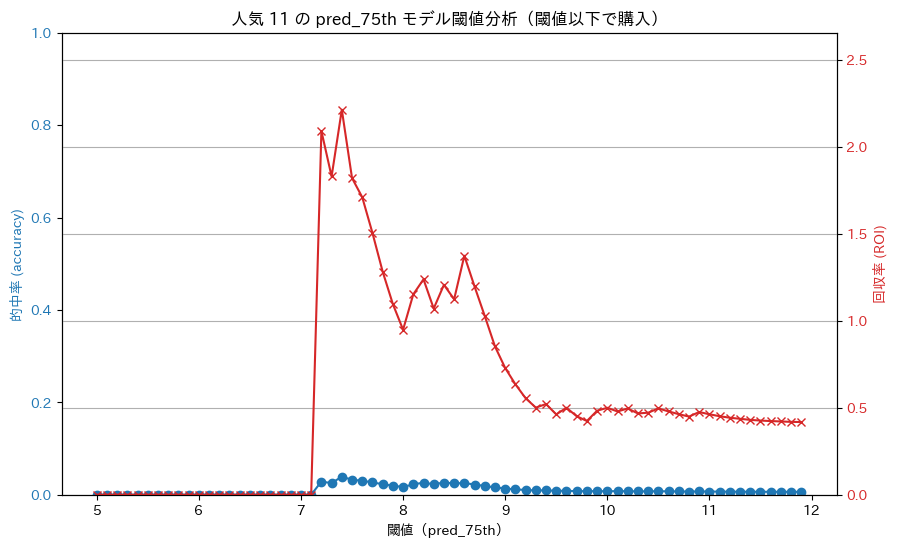

In [293]:
import matplotlib.pyplot as plt

# -----------------------------
# 設定
# -----------------------------
target_popularity = 11    # 注目する人気
target_percentile = 75    # 使用するパーセンタイル
bet_amount = 100          # 賭け金
thresholds = np.arange(0, 12.00, 0.1)  # 閾値の範囲（0~1, 0.05刻み）

accuracy_list = []
roi_list = []

# 指定人気のみ抽出
df_pop = full_pred_df[full_pred_df["popularity"] == target_popularity].copy()

# 閾値ごとに的中率・ROIを計算
for th in thresholds:
    df_bet = df_pop[df_pop[f"pred_{target_percentile}th"] <= th].copy()
    total_bets = len(df_bet)
    hits = (df_bet["finish_rank"] == 1).sum()
    total_payout = (df_bet["odds"] * bet_amount * (df_bet["finish_rank"] == 1)).sum()
    
    accuracy = hits / total_bets if total_bets > 0 else np.nan
    roi = total_payout / (total_bets * bet_amount) if total_bets > 0 else np.nan
    
    accuracy_list.append(accuracy)
    roi_list.append(roi)

# -----------------------------
# グラフ描画
# -----------------------------
fig, ax1 = plt.subplots(figsize=(10,6))

color = 'tab:blue'
ax1.set_xlabel(f"閾値（pred_{target_percentile}th）")
ax1.set_ylabel("的中率 (accuracy)", color=color)
ax1.plot(thresholds, accuracy_list, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0,1)

ax2 = ax1.twinx()  # 同じx軸でROIも表示
color = 'tab:red'
ax2.set_ylabel("回収率 (ROI)", color=color)
# NaNを除外して上限を計算
roi_max = np.nanmax(roi_list)
if np.isnan(roi_max) or roi_max == 0:
    roi_max = 1.0  # 安全値
ax2.plot(thresholds, roi_list, color=color, marker='x')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, roi_max * 1.2)

plt.title(f"人気 {target_popularity} の pred_{target_percentile}th モデル閾値分析（閾値以下で購入）")
plt.grid(True)
plt.show()

